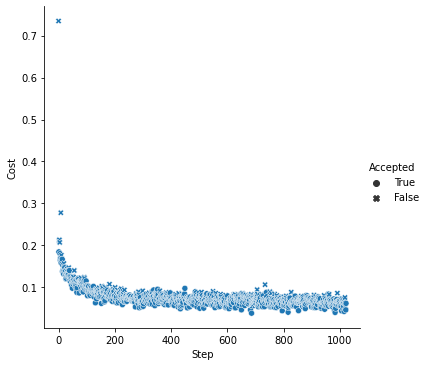

In [1]:
%matplotlib inline
import dill
with open('./storage', 'rb') as f:
    test_storage = dill.load(f)

with open('./qasvm', 'rb') as f:
    test_qasvm = dill.load(f)

test_storage.plot()

In [2]:
from pathlib import Path
import numpy as np
DATA_DIR = Path('/home/quic/QUIC-Projects/summary_ipynb/2021/10 October/15 Fri/Exp2(trs=64)')
X = np.load(DATA_DIR / 'DataSets/X.npy')
Xt = np.load(DATA_DIR / 'DataSets/Xt.npy')
y = np.load(DATA_DIR / 'DataSets/y.npy')
yt = np.load(DATA_DIR / 'DataSets/yt.npy')

In [3]:
import dill
from tqdm.notebook import tqdm
# with open(DATA_DIR / 'Samples/Circuit #15/layer=4/4/nqsvm', 'rb') as f:
with open(DATA_DIR / 'Samples/Circuit #15/layer=5/1/nqsvm', 'rb') as f:
    qasvm = dill.load(f)

_init = qasvm.parameters.copy()
_init.update(qasvm.initial_point)
var_qc = qasvm.var_form.assign_parameters(dict(zip(qasvm.var_form.parameters, _init)))
var_qc.save_statevector()
result = qasvm.quantum_instance.execute(var_qc)
initial_point = np.abs(result.get_statevector()) ** 2

from copy import deepcopy
from classifiers.quantum.qasvm import PseudoNormQSVM
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
feature_map = deepcopy(qasvm.feature_map)

pqasvm = PseudoNormQSVM(data=qasvm.data, label=qasvm.label, quantum_instance=qasvm.quantum_instance, lamda=qasvm.lamda, feature_map=feature_map, var_form=None, initial_point=initial_point)

storage = CostParamStorage()
optimizer = tSPSA(maxiter=2**15, blocking=True, last_avg=16, callback=storage)
for epoch in tqdm(range(1, 2**15 + 1)):
    optimizer.step(pqasvm.cost_fn, pqasvm.parameters)
    if storage.num_accepted() > 2 * 16 and storage.last_cost_avg(2 * 16, ignore_rejected=True) < \
            storage.last_cost_avg(16, ignore_rejected=True):
        break
pqasvm.parameters = storage.last_avg(16, ignore_rejected=True)
last_cost = storage.last_cost_avg(16, ignore_rejected=True)

  0%|          | 0/32768 [00:00<?, ?it/s]

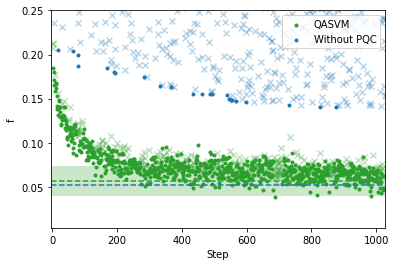

In [16]:
import matplotlib.pyplot as plt
color2, _, color1 = '#1f77b4', '#ff7f0e', '#2ca02c'
# df1 = storage.data.iloc[:len(qasvm_storage.data)]
df1 = test_storage.data
df2 = storage.data
plt.scatter(df1.loc[df1['Accepted']==True]['Step'], df1.loc[df1['Accepted']==True]['Cost'], marker='.', c=color1, label='QASVM')
#plt.scatter(range(len(df1.loc[df1['Accepted']==True])), df1.loc[df1['Accepted']==True]['Cost'], marker='.', c=color1, label='QASVM')
plt.scatter(df1.loc[df1['Accepted']==False]['Step'], df1.loc[df1['Accepted']==False]['Cost'], marker='x', alpha=0.3, c=color1)
plt.scatter(df2.loc[df2['Accepted']==True]['Step'], df2.loc[df2['Accepted']==True]['Cost'], marker='.', c=color2, label='Without PQC')
#plt.scatter(range(len(df2.loc[df2['Accepted']==True])), df2.loc[df2['Accepted']==True]['Cost'], marker='.', c=color2, label='Without PQC')
plt.scatter(df2.loc[df2['Accepted']==False]['Step'], df2.loc[df2['Accepted']==False]['Cost'], marker='x', alpha=0.3, c=color2)
plt.axhline(last_cost, 0, 1, color=color2, linestyle='--')
plt.axhline(test_storage.last_cost_avg(16, ignore_rejected=True), 0, 1, color=color1, linestyle='--')
plt.axhspan(ymin=test_storage.last_cost_avg(16, ignore_rejected=True)-2*test_storage.last_cost_std(16, ignore_rejected=True),
            ymax=test_storage.last_cost_avg(16, ignore_rejected=True)+2*test_storage.last_cost_std(16, ignore_rejected=True),
            xmin=0, xmax=1, facecolor=color1, alpha=0.25)
plt.ylim([None, 0.25])
plt.xlim([-5, len(df1)+5])
plt.xlabel('Step')
plt.ylabel('f')
plt.legend(loc='upper right')
plt.show()

In [17]:
_tmp_path = DATA_DIR / 'Classical'
_tmp_path.mkdir(exist_ok=True)
pqasvm.save(_tmp_path / 'qasvm_blocking')
storage.save(_tmp_path / 'storage_blocking')


In [24]:
fvector = qasvm.f(Xt)
accuracy = sum(np.where(fvector*(2*yt-1)>0, 1, 0))/150
import json
with open('./full_result.json', 'w') as f:
    json.dump(dict(f=list(fvector), accuracy=accuracy), f)